In [1]:
import cv2 as cv
import numpy as np
import random
from PIL import Image
from image_utils import *
from canvas import *
from scipy import ndimage
from sampling import Sampler
from config import parse_cfg
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
def display(img):
    return Image.fromarray(img)

In [3]:
def place_above(canvas, dot, num_coords):

    top_left_row = num_coords['min_col'] + random.randint(-20, 20)
    top_left_col = num_coords['min_row'] - dot.shape[0] - random.randint(0, 10)

    return canvas.draw_on_paper(dot, (top_left_row, top_left_col))

def place_below(canvas, num, dot_coords):
        
    top_left_col = dot_coords['max_row'] + random.randint(0, 10)
    top_left_row = dot_coords['min_col'] + random.randint(-20, 20)
    
    return canvas.draw_on_paper(num, (top_left_row, top_left_col))

def place_right(canvas, num, dot_coords):
    
    top_left_col = dot_coords['min_row'] + random.randint(-20, 20)
    top_left_row = dot_coords['max_col'] + random.randint(0, 10)
    
    return canvas.draw_on_paper(num, (top_left_row, top_left_col))

def place_left(canvas, num, dot_coords):
    
    top_left_col = dot_coords['min_row'] + random.randint(-20, 20)
    top_left_row = dot_coords['min_col'] - num.shape[1] - random.randint(0, 10)
    
    return canvas.draw_on_paper(num, (top_left_row, top_left_col))

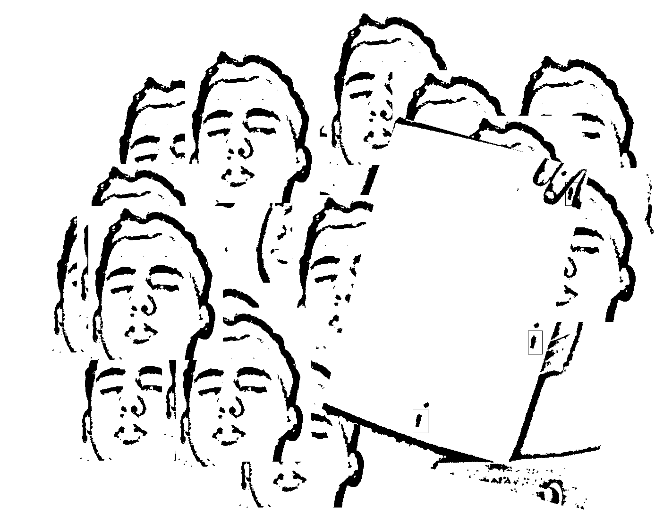

In [39]:
blanks = get_canvases('canvases')
blank_sampler = Sampler(blanks)

a = blank_sampler.get_sample()
a.img = adaptive_thresh(a.img)

names, imgs = get_img_data('nums/1')
num_sampler = Sampler(imgs)

func = [place_above,]

bbox = {}

dot = np.load('dots/1.npy')
dot = adaptive_thresh(dot)

for i in range(3):
    num = num_sampler.get_sample()
    scalar = random.uniform(1.8, 2)
    
    num = cv.resize(num, (int(num.shape[0]*scalar), int(num.shape[1]*scalar)))
    num = adaptive_thresh(num)
    
    x1 = random.randint(a.top_left[0],  a.top_right[0])
    y1 = random.randint(a.top_left[1],  a.bot_left[1])
    
    while not a.draw_on_paper(num, (x1, y1)):
        x1 = random.randint(a.top_left[0],  a.top_right[0])
        y1 = random.randint(a.top_left[1],  a.bot_left[1])
    
    # placed num
    
    
    if '1' not in bbox:
        bbox['1'] = []
        
#         # tl tr br bl
    
    top_left, top_right, bot_right, bot_left = get_corners((x1, y1), num)
    bbox['1'].append((top_left, top_right, bot_right, bot_left))
    
    num_coords = {}
    num_coords['min_row'] = top_left[1]
    num_coords['max_row'] = bot_right[1]
    num_coords['min_col'] = top_left[0]
    num_coords['max_col'] = bot_right[0]

    np.random.shuffle(func)
    
    scalar = .6    
    dz = dot.copy()
    dz = cv.resize(dz, ( int(dz.shape[0]*scalar), int(dz.shape[1]*scalar)))
    dz = adaptive_thresh(dz)

    for f in func:
        if f(a, dz, num_coords):
            break
            
            
def totally_inside_paper(top_left_obj, obj, canvas):

    for corner in get_corners(top_left_obj, obj):
         if cv.pointPolygonTest(canvas.contours, (corner[1], corner[0]), False) < 0.0:
                return False
    
    return True

deg = -15

a.rotate(deg)
rad = np.deg2rad(deg)
rt = np.array([[np.cos(rad), np.sin(rad)], [-np.sin(rad), np.cos(rad)]])

for k,v in bbox.items():
    for obj in v:
        nw = np.dot(rt, np.array(obj).T - np.array([1280/2, 720/2]).reshape(2,-1)) + np.array([a.img.shape[1]/2, a.img.shape[0]/2]).reshape(2,-1)
        nw = nw.astype(np.int32)

        a.img = cv.rectangle(a.img, tuple(nw[:, 0]), tuple(nw[:, 2]), (0), 1)

k = np.load('backgrounds/1.npy')

cnt = 30
for i in range(cnt):

    y1 = random.randint(0, a.img.shape[0])
    x1 = random.randint(0, a.img.shape[1])

    while(totally_inside_paper((x1, y1), k, a)):
        y1 = random.randint(0, a.img.shape[0])
        x1 = random.randint(0, a.img.shape[1])

    a.draw_on_background(k, (x1, y1))

display(cv.resize(a.img, (672, 512)))